# SPC Data Analysis

---

[Alejandro Ciuba](https://alejandrociuba.github.io), alejandrociuba@pitt.edu

---

## Summary

This Jupyter Notebook explores the Semantic Pleonasm Corpus from [this paper](). The goals are:

1. General exploration of the corpus, including word counts, quantitative plots, etc.
2. Discovery of potential machine-learning features for semantic pleonasm detection.
---

## Setup

### Imprts

In [1]:
from collections import defaultdict

from nltk import (
    word_tokenize,
    FreqDist,
    )

from nltk.corpus import stopwords
from pathlib import Path

import pandas as pd
import seaborn as sns
import string

### Globals

In [2]:
SPC = Path("./data/SPC/")
data = SPC / "SPC.json"

In [3]:
stop_tokens = set(word_tokenize(' '.join(stopwords.words(fileids='english'))))

### Functions

In [4]:
def tokenize(sentence: str) -> list[str]:
    return word_tokenize(sentence.strip().lower())

In [5]:
def strip_punct(sentence: str) -> str:
    return ''.join(filter(lambda x: x not in string.punctuation, sentence))  # Gotten from GeeksForGeeks
    

In [6]:
#  Pleonasm will be UPPER to ensure duplicate words do not conflict with our data analysis
# Currently keeping punctuation to help identify parts-of-speech later
def full_sentence_tokenize(row: pd.Series) -> list[str]:
    before, after, pleonasm = row.before, row.after, row.consensus
    if pleonasm == 'neither':
        return word_tokenize(f"{before.strip().lower()} {after.strip().lower()}")
    elif pleonasm == 'both':
        before_pleonasm = before.split(" ")[-1]
        after_pleonasm = after.split(" ")[0]
        return word_tokenize(f"{' '.join(before.split(' ')[:-1]).lower()} {before_pleonasm.upper()} {after_pleonasm.upper()} {' '.join(after.split(' ')[1:]).lower()}")
    else:
        return word_tokenize(f"{before.strip().lower()} {pleonasm.strip().upper()} {after.strip().lower()}")

In [7]:
# Remove stop words to compare non-pleonasm content words and pleonasm content words
# NOTE: This words only on the full_sent column because we kept punctuation like apostrophes
def remove_stopwords(tokens: list[str]) -> list[str]:
    return list(filter(lambda x: x not in stop_tokens and x not in ["``", "..."], tokens))

### Prolog Code

In [8]:
%pprint  # Disable pretty printing

Pretty printing has been turned OFF


In [9]:
df = pd.read_json(data, lines=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   after        3019 non-null   object
 1   consensus    3019 non-null   object
 2   second       3019 non-null   object
 3   before       3019 non-null   object
 4   annotations  3019 non-null   object
 5   first        3019 non-null   object
dtypes: object(6)
memory usage: 141.6+ KB


In [10]:
### Preprocessing
df['full_sent'] = df.apply(full_sentence_tokenize, axis=1)

df.after = df.after.map(strip_punct)
df.before = df.before.map(strip_punct)

df.after = df.after.map(tokenize)
df.before = df.before.map(tokenize)

df["before_count"] = df.before.map(len)
df["after_count"] = df.after.map(len)

df["consensus"] = df.consensus.map(str.lower)

df.head(10)

,after,consensus,second,before,annotations,first,full_sent,before_count,after_count
0,"[can, of, flat, black, krylon]",stinking,stinking,"[i, walk, into, lowes, knowing, exactly, what,...",{'A3J2UG22S8BIW4': {'certainty': 'Somewhat cer...,lousy,"[i, walk, into, lowes, knowing, exactly, what,...",10,5
1,[treat],delectable,delectable,"[support, your, local, business, and, be, rewa...","{'A2ESBX4C2Q6TQY': {'certainty': 'Certain', 'e...",yummy,"[support, your, local, business, and, be, rewa...",9,1
2,"[thing, i, reflect, upon, the, lack, of, high,...",small,small,"[once, i, have, no, more, room, to, taste, eve...","{'A3B7TNVOISSZ2O': {'certainty': 'Certain', 'e...",slightest,"[once, i, have, no, more, room, to, taste, eve...",10,12
3,[process],check,verification,"[they, ve, followed, suit, with, chase, and, n...","{'A2Z750U1HCWVEE': {'certainty': 'Certain', 'e...",check,"[they, 've, followed, suit, with, chase, and, ...",14,1
4,"[gelatinous, purees, that, were, finessed, fla...",sick,green,"[also, i, thought, some, of, the, plating, had...",{'A2A1FS0KVLJ9ZT': {'certainty': 'Somewhat cer...,sick,"[also, i, thought, some, of, the, plating, had...",23,13
5,"[and, happy, to, do, her, job]",cheerful,cheerful,[always],"{'AEWPAZBYA7XE': {'certainty': 'Certain', 'exp...",smiling,"[always, CHEERFUL, and, happy, to, do, her, jo...",1,6
6,"[fruit, pulp]",plain,pure,"[freshly, squeezed, and, no, additives, just]",{'A1KAGE2AVL6ZGO': {'certainty': 'Somewhat cer...,plain,"[freshly, squeezed, and, no, additives, ,, jus...",6,2
7,"[by, there, is, a, movie, theater, which, is, ...",next,close,"[fry, s, is]","{'A2OVMADBMBNWFK': {'certainty': 'Certain', 'e...",next,"[fry, 's, is, NEXT, by, ,, there, is, a, movie...",3,11
8,[],neither,thinking,"[restaurants, on, a, saturday, afternoon, and,...","{'A3J2UG22S8BIW4': {'certainty': 'Certain', 'e...",rational,"[restaurants, on, a, saturday, afternoon, ,, a...",18,0
9,"[top, shelf]",top,top,"[the, beers, here, are, way]",{'A1GYO6CJMVA9ZA': {'certainty': 'Somewhat cer...,upper,"[the, beers, here, are, way, TOP, top, shelf, .]",5,2


In [11]:
# Focus on the important data
df = df.drop(labels=["annotations"], axis=1)
df.head(10)

,after,consensus,second,before,first,full_sent,before_count,after_count
0,"[can, of, flat, black, krylon]",stinking,stinking,"[i, walk, into, lowes, knowing, exactly, what,...",lousy,"[i, walk, into, lowes, knowing, exactly, what,...",10,5
1,[treat],delectable,delectable,"[support, your, local, business, and, be, rewa...",yummy,"[support, your, local, business, and, be, rewa...",9,1
2,"[thing, i, reflect, upon, the, lack, of, high,...",small,small,"[once, i, have, no, more, room, to, taste, eve...",slightest,"[once, i, have, no, more, room, to, taste, eve...",10,12
3,[process],check,verification,"[they, ve, followed, suit, with, chase, and, n...",check,"[they, 've, followed, suit, with, chase, and, ...",14,1
4,"[gelatinous, purees, that, were, finessed, fla...",sick,green,"[also, i, thought, some, of, the, plating, had...",sick,"[also, i, thought, some, of, the, plating, had...",23,13
5,"[and, happy, to, do, her, job]",cheerful,cheerful,[always],smiling,"[always, CHEERFUL, and, happy, to, do, her, jo...",1,6
6,"[fruit, pulp]",plain,pure,"[freshly, squeezed, and, no, additives, just]",plain,"[freshly, squeezed, and, no, additives, ,, jus...",6,2
7,"[by, there, is, a, movie, theater, which, is, ...",next,close,"[fry, s, is]",next,"[fry, 's, is, NEXT, by, ,, there, is, a, movie...",3,11
8,[],neither,thinking,"[restaurants, on, a, saturday, afternoon, and,...",rational,"[restaurants, on, a, saturday, afternoon, ,, a...",18,0
9,"[top, shelf]",top,top,"[the, beers, here, are, way]",upper,"[the, beers, here, are, way, TOP, top, shelf, .]",5,2


---

## 1. General Exploration

### Descriptive Statistics

In [12]:
df.head(10)

,after,consensus,second,before,first,full_sent,before_count,after_count
0,"[can, of, flat, black, krylon]",stinking,stinking,"[i, walk, into, lowes, knowing, exactly, what,...",lousy,"[i, walk, into, lowes, knowing, exactly, what,...",10,5
1,[treat],delectable,delectable,"[support, your, local, business, and, be, rewa...",yummy,"[support, your, local, business, and, be, rewa...",9,1
2,"[thing, i, reflect, upon, the, lack, of, high,...",small,small,"[once, i, have, no, more, room, to, taste, eve...",slightest,"[once, i, have, no, more, room, to, taste, eve...",10,12
3,[process],check,verification,"[they, ve, followed, suit, with, chase, and, n...",check,"[they, 've, followed, suit, with, chase, and, ...",14,1
4,"[gelatinous, purees, that, were, finessed, fla...",sick,green,"[also, i, thought, some, of, the, plating, had...",sick,"[also, i, thought, some, of, the, plating, had...",23,13
5,"[and, happy, to, do, her, job]",cheerful,cheerful,[always],smiling,"[always, CHEERFUL, and, happy, to, do, her, jo...",1,6
6,"[fruit, pulp]",plain,pure,"[freshly, squeezed, and, no, additives, just]",plain,"[freshly, squeezed, and, no, additives, ,, jus...",6,2
7,"[by, there, is, a, movie, theater, which, is, ...",next,close,"[fry, s, is]",next,"[fry, 's, is, NEXT, by, ,, there, is, a, movie...",3,11
8,[],neither,thinking,"[restaurants, on, a, saturday, afternoon, and,...",rational,"[restaurants, on, a, saturday, afternoon, ,, a...",18,0
9,"[top, shelf]",top,top,"[the, beers, here, are, way]",upper,"[the, beers, here, are, way, TOP, top, shelf, .]",5,2


In [13]:
df[["before_count", "after_count"]].describe().T

,count,mean,std,min,25%,50%,75%,max
before_count,3019.0,11.366678,8.785853,0.0,5.0,9.0,16.0,77.0
after_count,3019.0,8.776747,8.441659,0.0,2.0,7.0,12.0,67.0


<Axes: xlabel='before_count', ylabel='Count'>

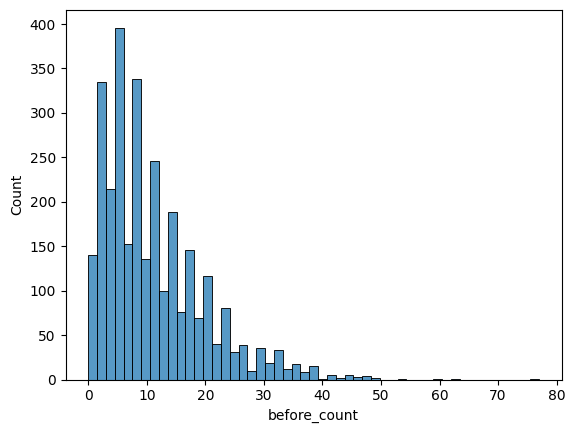

In [14]:
sns.histplot(df, x='before_count')

<Axes: xlabel='after_count', ylabel='Count'>

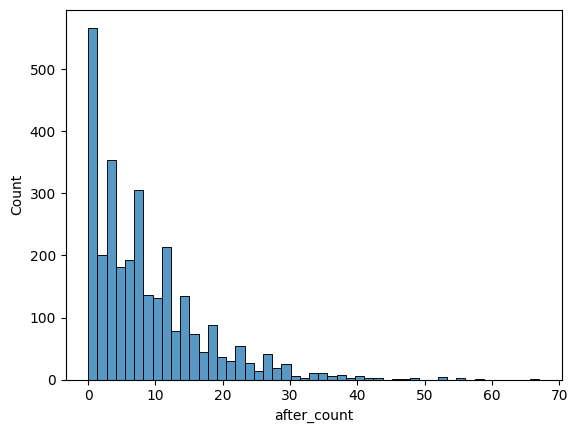

In [15]:
sns.histplot(df, x='after_count')

### Most Common Pleonasms

In [16]:
len(df.consensus.unique())  # Number of unique pleonasms

1059

In [17]:
df.consensus.value_counts().head(10)

consensus
neither      1283
small          16
both           16
little         16
big            14
large          13
soft            9
dirty           8
bad             8
different       8
Name: count, dtype: int64

#### Pleonasms Vs. General Content Words

In [18]:
content_words = FreqDist([tok for toks in df.full_sent.to_list() for tok in remove_stopwords(toks) if tok.lower() == tok and tok not in string.punctuation])
content_words.most_common(10)

[('like', 269), ('place', 216), ('one', 183), ('food', 169), ('get', 167), ('good', 137), ('time', 134), ('really', 116), ('people', 116), ('service', 114)]

Ratio between pleonasm vs. non-pleonasm instances of pleonasm words

In [19]:
pleonasms = defaultdict(lambda: [0, 0, 0])  # First index is pleonasm count, second is non-pleonasm count, third is percentage

for pleonasm in df.consensus.to_list():
    pleonasms[pleonasm][0] += 1

for row in df.itertuples():
    for tok in row.full_sent:
        if tok in list(pleonasms.keys()):  # Automatically ignores upper case!
            pleonasms[tok][1] += 1

assert pleonasms['neither'][0] == 1283

percentages = sorted(list(map(lambda x: pleonasms[x][0] / (pleonasms[x][0] + pleonasms[x][1]), pleonasms)))

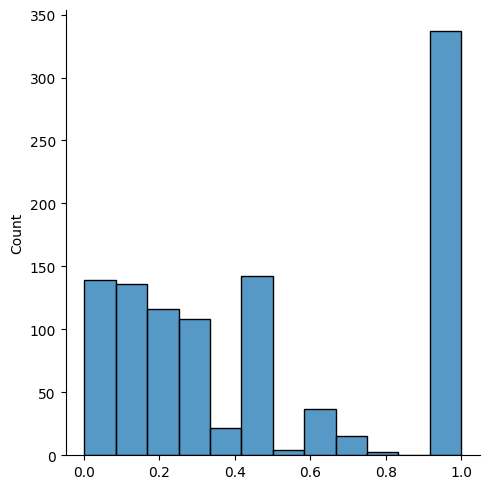

In [20]:
sns.displot(data=percentages)  # Plot the percentages as a distribution